# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from minisom import MiniSom as SOM
import matplotlib.pyplot as plt
import matplotlib.patches

#from utils import load_data, pca_componentwise, plot_all_experiments, test_train_split, normalize_files

print("Libraries imported.")

Libraries imported.


# Constants

In [2]:
DATA_DIRECTORY = r"C:\Users\Daniel\Documents\Studium\7. Semester (WS 2020.21)\Seminar Data Mining in der Produktion\Gruppenarbeit\Data"
NORMALIZATION_NORM = "l2"
TEST_TRAIN_SPLIT = 0.1
RANDOM_SEED = 1     # for reproducibility

EXPERIMENT_NAMES = ['C11', 'C13', 'C14', 'C15', 'C16', 'C7', 'C8', 'C9']

# Components
COMPONENTS = [
    ['A_1', 'A_2', 'A_3', 'A_4', 'A_5'],
    ['B_1', 'B_2', 'B_3', 'B_4', 'B_5'],
    ['C_1', 'C_2', 'C_3', 'C_4', 'C_5'],
    ['L_1', 'L_2'],
    ['L_3', 'L_6'],
    ['L_4', 'L_5'],
    ['L_7', 'L_8'],
    ['L_9', 'L_10']
]

L_cols = ['L_1', 'L_2', 'L_3', 'L_4', 'L_5', 'L_6', 'L_7', 'L_8', 'L_9', 'L_10']
A_cols = ['A_1', 'A_2', 'A_3', 'A_4', 'A_5']
B_cols = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5']
C_cols = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5']
column_groups = [L_cols, A_cols, B_cols, C_cols]

COLORMAP = {
    "L_2": "b",
    "L_6": "g",
    "L_8": "r",
    "L_10": "c",
    "A_5": "m",
    "B_4": "y",
    "B_5": "k",
    "C_5": "tab:orange"
}

print("Constants set.")

Constants set.


# Utility functions

In [3]:
import os
from typing import List, Tuple

import pandas as pd
from sklearn.decomposition import PCA
import sklearn.preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot


def load_data(directory: str):
    _filepaths = [directory + "/" + filename for filename in os.listdir(directory)]

    files = [pd.read_csv(path) for path in _filepaths]

    # Merge C13-1 and C13-2 as well as C7-1 and C7-2
    c13 = pd.concat([files[1], files[2]])
    c7 = pd.concat([files[6], files[7]])

    files[1] = c13
    files[6] = c7

    files.pop(2)
    files.pop(7)

    # Drop Timestamp column
    files = [df.drop("Timestamp", axis=1) for df in files]


    # Handle NaN
    files = [df.dropna() for df in files]

    return files


def normalize_files(files: List[pd.DataFrame], normalization_norm: str):
    column_names = files[0].columns
    files = [sklearn.preprocessing.normalize(df, norm=normalization_norm) for df in files]
    files = [pd.DataFrame(array, columns=column_names) for array in files]

    return files


def pca_componentwise(files: List[pd.DataFrame], components: list) -> List[pd.DataFrame]:
    processed_files = []

    for file in files:
        new_columns = []

        for component in components:
            component_subset = file[component]
            pca = PCA(n_components=1)

            new_col = pca.fit_transform(component_subset)
            component_column = pd.DataFrame(new_col)
            new_columns.append(component_column)

        result = pd.concat(new_columns, axis=1)
        processed_files.append(result)

    return processed_files


def plot_all_experiments(datasets: list, experiment_names: list, test_train_split: float = None,
                         savefig: str = "C:/Users/Daniel/Desktop/plot.png", ols_line: bool = False) -> None:
    fig, ax = plt.subplots(8, 1)
    fig.set_size_inches(6, 24)

    for i, dataset in enumerate(datasets):
            axis = ax[i]
            axis.scatter(x=dataset.index, y=dataset[0], s=1)
            axis.set_title(f"Experiment No. {experiment_names[i]}")

            if test_train_split is not None:    # plot vertical line
                test_train_split_index = int(len(dataset) * test_train_split)
                axis.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

            if ols_line:
                x = sm.add_constant(dataset.index)
                y = dataset[0]
                abline_plot(model_results=sm.OLS(y, x).fit(), ax=axis, color="black", linewidth=1)

    plt.tight_layout()

    if savefig:
        plt.savefig(savefig)
    plt.show()


def test_train_split(files: List[pd.DataFrame], split: float) -> Tuple[List[pd.DataFrame], List[pd.DataFrame]]:
    # Split train and test data -> first x% taken (not randomly)
    def split_df_not_randomly(df, split: float):
        split_index = int(len(df) * split)
        return df[:split_index], df[split_index:]

    train_files, test_files = zip(*[split_df_not_randomly(df, split) for df in files])

    return train_files, test_files

print("Utils imported.")

Utils imported.


# Load and preprocess data

In [4]:
files = load_data(directory=DATA_DIRECTORY)

files = normalize_files(files, normalization_norm=NORMALIZATION_NORM)

#cols_to_include = ["L_2", "L_6", "L_8", "L_10", "L_3", "A_4", "B_5", "C_4"]    Eyeballing from correlation_analysis.py
#cols_to_include = ["L_2", "L_6", "L_7", "L_8", "L_10", "A_4", "A_5", "B_3", "B_4", "B_5", "C_4", "C_5"]  # regression: threshold 0.75
#cols_to_include = ["L_2", "L_6", "L_7", "L_8", "L_10", "A_4", "A_5", "B_4", "B_5", "C_4", "C_5"]  # regression: threshold 0.70
cols_to_include = ["L_2", "L_6", "L_8", "L_10", "A_5", "B_4", "B_5", "C_5"]  # regression: threshold 0.6
#cols_to_include = ["A_5", "B_4", "L_2"]
files = [file[cols_to_include] for file in files]
# files = pca_componentwise(files, components=COMPONENTS)

train_files, test_files = test_train_split(files, split=TEST_TRAIN_SPLIT)

#cols_to_drop = ["C_5", "B_5", "A_5", 'L_3', 'L_4', 'L_6', 'L_7', 'L_8', 'L_9', 'L_10']
#s = s.drop(cols_to_drop, axis=1)

#s.sum(axis=1).plot()
#c = s[cols_to_include].corr().abs()

TRAINING_DATA = pd.concat(train_files)

print("Loaded and preprocessed data.")

Loaded and preprocessed data.


# Abweichung von Median

In [ ]:
def distance(x: pd.Series, array: pd.DataFrame, norm="l2"):
    """Row-wise distance of array from point x."""
    if norm in ["l2", "euclidean"]:
        order = 2
    elif norm in ["l1", "manhattan"]:
        order = 1
    else:
        order = norm

    return pd.DataFrame(np.linalg.norm(array - x, ord=order, axis=1))

#medians = [pd.DataFrame(train).median() for train in train_files]
median = TRAINING_DATA.median()

#anomalies = [distance(median, file, norm="l2") for file, median in zip(files, medians)]
anomalies = [distance(median, file, norm="l2") for file in files]

plot_all_experiments(anomalies, EXPERIMENT_NAMES, test_train_split=TEST_TRAIN_SPLIT, ols_line=True,
                     savefig=True)

# Abweichung vom Vorherigen

In [ ]:
predecessors = [pd.DataFrame(file).shift(1) for file in files]
originals = [pd.DataFrame(file) for file in files]

distances = [pd.DataFrame(np.linalg.norm(orig - pred, ord=2, axis=1)) for orig, pred in zip(originals, predecessors)]

experiment_names = ['C11', 'C13', 'C14', 'C15', 'C16', 'C7', 'C8', 'C9']

plot_all_experiments(distances, experiment_names, test_train_split=None)

# Isolation Forest
Predictions: -1 -> outlier, 1 -> inlier

In [ ]:
%%time
train, all_data = train_files[0], files[0]

model = IsolationForest(random_state=RANDOM_SEED)
model.fit(train)
predictions = pd.DataFrame(model.predict(all_data))

# Plot
test_train_split_index = int(len(all_data) * TEST_TRAIN_SPLIT)

predictions["color"] = predictions[0].apply(lambda x: "blue" if x == 1.0 else "red")
plt.scatter(x=predictions.index, y=predictions[0], c=predictions["color"], s=1)
plt.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

# Elliptic Envelope

In [ ]:
%%time
train, all_data = train_files[0], files[0]

model = EllipticEnvelope(random_state=RANDOM_SEED)
model.fit(train)
predictions = pd.DataFrame(model.predict(all_data))

# Plot
test_train_split_index = int(len(all_data) * TEST_TRAIN_SPLIT)

predictions["color"] = predictions[0].apply(lambda x: "blue" if x == 1.0 else "red")
plt.scatter(x=predictions.index, y=predictions[0], c=predictions["color"], s=1)
plt.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

# OneClass SVM

In [5]:
%%time
models_svm = [OneClassSVM(kernel="rbf", nu=0.01).fit(train) for train in train_files]
predictions_svm = [pd.DataFrame(model.decision_function(files[i])) for i, model in enumerate(models_svm)]

Wall time: 580 ms


In [6]:
WINDOW = 300
rolling_medians = [-1 * pred.rolling(WINDOW).median() for pred in predictions_svm]

#plot_all_experiments(rolling_medians, EXPERIMENT_NAMES, TEST_TRAIN_SPLIT,
#                     ols_line=True, savefig="C:/Users/Daniel/Desktop/svm_rbf_nu_0001_median_win1.png")

### Localization

In [22]:
%%time
def get_bmu(x: pd.Series, model: OneClassSVM) -> np.ndarray:
    support_vectors = model.support_vectors_
    distances = np.linalg.norm(support_vectors - x.to_numpy(), axis=1)
    min_index = pd.Series(distances).idxmin()

    return support_vectors[min_index]

def most_diverging_feature(x: pd.Series, model: OneClassSVM) -> str:
    bmu = get_bmu(x, model)
    return (x - bmu).abs().idxmax()

oc_svm_anom_loc = [[most_diverging_feature(row, models_svm[i])
                          for index, row in file.iterrows()]
                         for i, file in enumerate(files)]

colors_oc_svm_anom_loc = [[COLORMAP[el] for el in file] for file in oc_svm_anom_loc]

print("Computed OneClassSVM Anomaly localization.")

Computed OneClassSVM Anomaly localization.
Wall time: 4min 16s


<ipython-input-25-902ca3dc7dfd>:7: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in COLORMAP.items()]


TypeError: 'int' object is not iterable

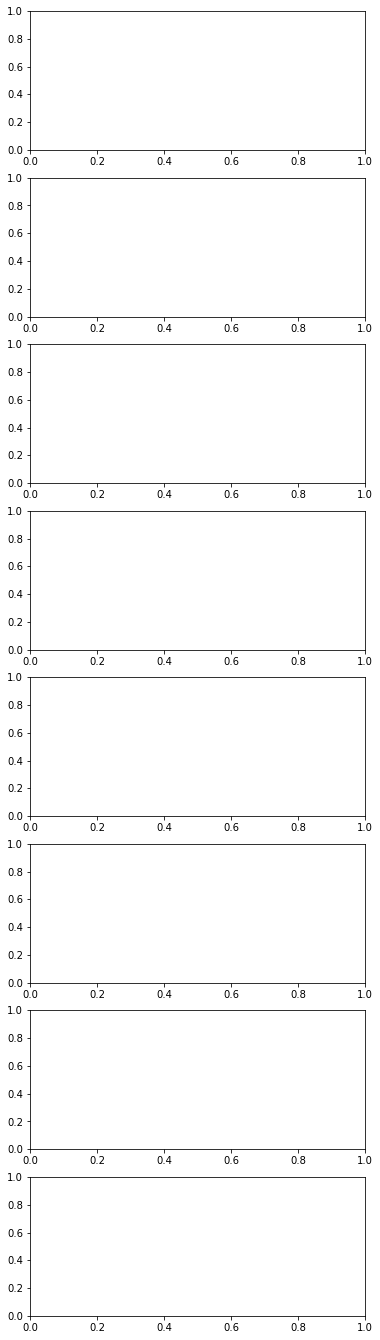

In [25]:
# Plot
fig, ax = plt.subplots(8, 1)
fig.set_size_inches(6, 24)

patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in COLORMAP.items()]

for i, dataset in enumerate(files):
    axis = ax[i]
    axis.scatter(x=rolling_medians[i].index, y=rolling_medians[i], c=colors_oc_svm_anom_loc[i], s=1)
    axis.set_title(f"Experiment No. {EXPERIMENT_NAMES[i]}")

    # Add test_train_split line
    test_train_split_index = int(len(dataset) * TEST_TRAIN_SPLIT)
    axis.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

    # Add legend
    axis.legend(handles=patches, loc="center right", bbox_to_anchor=(1.22, 0.5))
    axis.set_ylim(bottom=0.0)   # plot only outliers (decision_function <= 0 umgedreht durch -1 oben)

plt.tight_layout()

plt.savefig("C:/Users/Daniel/Desktop/OneClassSVM_anom_loc.png")
plt.show()

In [14]:
%%time
def set_others_na(l, value: str) -> list:
    return [(el if el == value else np.NaN) for el in l]

WINDOW = 300

occurrences_all = [
    [
        pd.Series(set_others_na(experiment, "L_2")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "L_6")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "L_8")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "L_10")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "A_5")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "B_4")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "B_5")).rolling(WINDOW).count() / WINDOW,
        pd.Series(set_others_na(experiment, "C_5")).rolling(WINDOW).count() / WINDOW
    ] for experiment in oc_svm_anom_loc
]

print("Occurrences computed.")

Occurrences computed.
Wall time: 772 ms


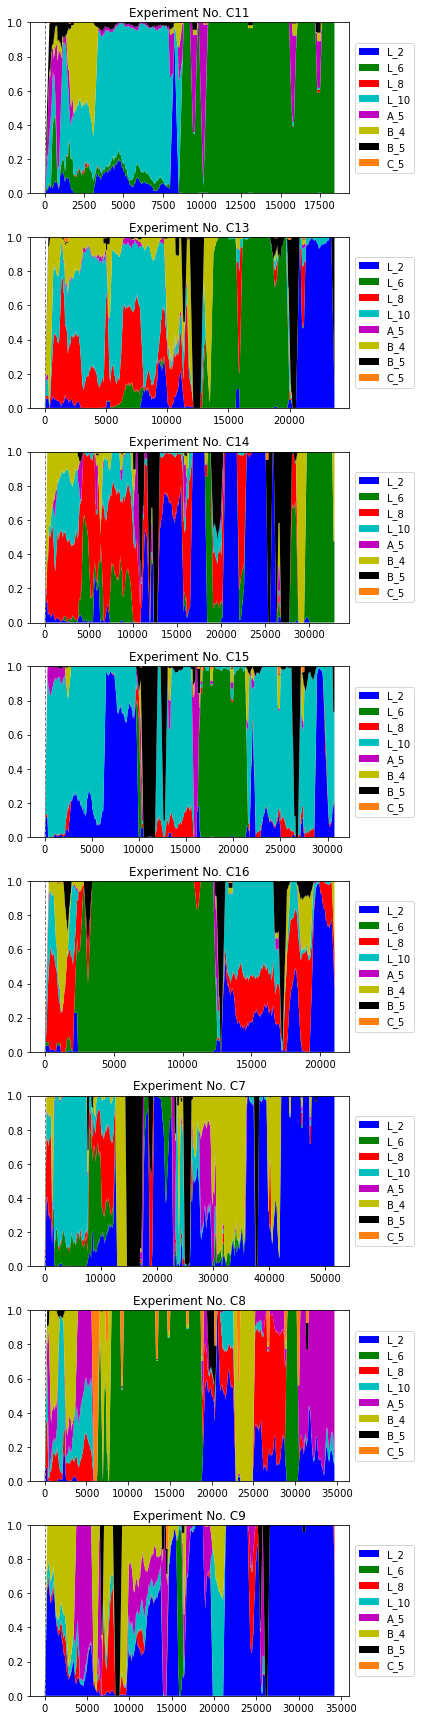

In [20]:
fig, ax = plt.subplots(8, 1)
fig.set_size_inches(6, 24)

for i, experiment in enumerate(occurrences_all):
    axis = ax[i]
    axis.set_title(f"Experiment No. {EXPERIMENT_NAMES[i]}")

    index = list(range(len(experiment[0])))
    axis.stackplot(index, *occurrences_all[i],
                   labels=COLORMAP.keys(),
                   colors=COLORMAP.values())

    # Add test_train_split line
    test_train_split_index = int(len(experiment[0]) * TEST_TRAIN_SPLIT)
    axis.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)

    axis.legend(loc="center right", bbox_to_anchor=(1.22, 0.5))
    axis.set_ylim([0, 1])

plt.tight_layout()

plt.savefig("C:/Users/Daniel/Desktop/OneClassSVM_anom_loc_stackplot.png")
plt.show()

# SOM

In [ ]:
SOM_MAP_X_DIMENSION = 10      # 50 as taken from research paper
SOM_MAP_Y_DIMENSION = 10     # 50 as taken from research paper
SOM_TRAINING_EPOCHS = 10000

def train_model(training_data):
    model = SOM(x=SOM_MAP_X_DIMENSION, y=SOM_MAP_Y_DIMENSION, input_len=training_data.shape[1], random_seed=RANDOM_SEED)
    model.train(training_data, num_iteration=SOM_TRAINING_EPOCHS, verbose=True)
    return model

models = [train_model(train.to_numpy()) for train in train_files]
#model = train_model(TRAINING_DATA.to_numpy())

print("SOM models trained.")

### SOM: Activation on training data (above) and test data (below)

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(8, 2, sharex=True, sharey=True)
fig.set_size_inches(6, 24)

for i, test_file in enumerate(test_files):
    """
    frequencies = model.activation_response(train_files[i].to_numpy())
    ax[i, 0].pcolor(frequencies.T, cmap='Blues')
    ax[i, 0].set_title("Training")
    #plt.colorbar()
    """

    frequencies = models[i].activation_response(test_file.to_numpy())
    ax[i, 1].pcolor(frequencies.T, cmap='Oranges')
    ax[i, 1].set_title("Test")
    #plt.colorbar()

plt.show()

### SOM: Plot quantization errors

In [ ]:
converted_files = [[file[i:i+1].to_numpy() for i in range(len(file) - 1)] for file in files]    # always grab two data points and convert them to numpy (two needed because MiniSom will not evaluate a single one)

quantization_errors = [pd.DataFrame([model.quantization_error(data_point)
                                     for data_point in converted_files[j]])
                       for j, model in enumerate(models)]

rolling_medians_som = [qe.rolling(WINDOW).median() for qe in quantization_errors]

""" One model using same training data
quantization_errors = [pd.DataFrame([model.quantization_error(data_point)
                                     for data_point in converted_file])
                       for converted_file in converted_files]
"""

print("Quantization errors computed.")

In [ ]:
plot_all_experiments(rolling_medians_som, EXPERIMENT_NAMES, test_train_split=TEST_TRAIN_SPLIT,
                     ols_line=True, savefig="C:/Users/Daniel/Desktop/som_qe_window300.png")


# SOM Anomaly Localization

In [ ]:
def get_bmu_weights(model, row: pd.Series) -> np.ndarray:
    """Weights of Best Matching Unit"""
    return model._weights[model.winner(row.to_numpy())]
    
def most_diverging_feature(x: pd.Series, bmu_weights: np.ndarray) -> str:
    return (x - bmu_weights).abs().idxmax()
    
colormap = {
    "L_2": "b",
    "L_6": "g",
    "L_8": "r",
    "L_10": "c",
    "A_5": "m",
    "B_4": "y",
    "B_5": "k",
    "C_5": "tab:orange"
}

som_anom_loc = [[most_diverging_feature(row, get_bmu_weights(models[i], row))
                 for index, row in file.iterrows()]
                for i, file in enumerate(files)]

colors_som_anom_loc = [[colormap[el] for el in file] for file in som_anom_loc]
                           
print("Computed SOM Anomaly localization.")

In [ ]:
# Plot
fig, ax = plt.subplots(8, 1)
fig.set_size_inches(6, 24)

patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in colormap.items()]

for i, dataset in enumerate(files):
    axis = ax[i]
    axis.scatter(x=quantization_errors[i].index, y=quantization_errors[i], c=colors_som_anom_loc[i][:-1], s=1)
    axis.set_title(f"Experiment No. {EXPERIMENT_NAMES[i]}")

    # Add test_train_split line
    test_train_split_index = int(len(dataset) * TEST_TRAIN_SPLIT)
    axis.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)
    
    # Add legend
    axis.legend(handles=patches, loc="center right", bbox_to_anchor=(1.22, 0.5))

plt.tight_layout()

plt.savefig("C:/Users/Daniel/Desktop/SOM_anom_loc.png")
plt.show()

# OneClassSVM Decision Function

In [ ]:
parameters = {"kernel": ("linear", "rbf", "poly")}

svm_models = [OneClassSVM(tol=1).fit(train) for train in train_files]

distances_to_hyperplane = [pd.DataFrame(svm_models[i].decision_function(file)) for i, file in enumerate(files)]

plot_all_experiments(distances_to_hyperplane, EXPERIMENT_NAMES, test_train_split=TEST_TRAIN_SPLIT,
                     ols_line=True, savefig="C:/Users/Daniel/Desktop/svm.png")

# IsolationForest Decision Function

In [ ]:
forests = [IsolationForest(random_state=RANDOM_SEED).fit(train) for train in train_files]

avg_anomaly_score = [(pd.DataFrame(forests[i].decision_function(file)) * -1) for i, file in enumerate(files)]

plot_all_experiments(avg_anomaly_score, EXPERIMENT_NAMES, test_train_split=TEST_TRAIN_SPLIT,
                     ols_line=True, savefig="C:/Users/Daniel/Desktop/iso_forest_max_features8.png")

## IsolationForest Anomaly Localization

In [ ]:
colormap = {
    "L_2": "b",
    "L_6": "g",
    "L_8": "r",
    "L_10": "c",
    "A_5": "m",
    "B_4": "y",
    "B_5": "k",
    "C_5": "tab:orange"
}

predictions = [forests[i].predict(train) for i, train in enumerate(train_files)]

inlier_medians = [train_files[i][prediction == 1].median() for i, prediction in enumerate(predictions)]

predictions_all = [estimator.decision_function(files[i]) * -1 for i, estimator in enumerate(forests)]

def most_diverging_feature(x: pd.Series, inlier_median: pd.Series) -> str:
    return (x - inlier_median).abs().idxmax()

colors_per_prediction = [[colormap[most_diverging_feature(row, inlier_median)] for index, row in files[i].iterrows()] for i, inlier_median in enumerate(inlier_medians)]

print("Localization computed.")

In [ ]:
# Plot
fig, ax = plt.subplots(8, 1)
fig.set_size_inches(6, 24)

patches = [matplotlib.patches.Patch(color=value, label=key, edgecolor="b") for key, value in colormap.items()]

for i, dataset in enumerate(files):
    axis = ax[i]
    axis.scatter(x=dataset.index, y=predictions_all[i], c=colors_per_prediction[i], s=1)
    axis.set_title(f"Experiment No. {EXPERIMENT_NAMES[i]}")

    # Add test_train_split line
    test_train_split_index = int(len(dataset) * TEST_TRAIN_SPLIT)
    axis.axvline(x=test_train_split_index, color="grey", linestyle="--", linewidth=1)
    
    # Add legend
    axis.legend(handles=patches, loc="center right", bbox_to_anchor=(1.22, 0.5))

plt.tight_layout()

plt.savefig("C:/Users/Daniel/Desktop/Localized.png")
plt.show()

# Feature selection

In [ ]:
c11 = pd.read_csv(DATA_DIRECTORY + "/C11.csv")
c11 = c11.drop("Timestamp", axis=1)

fig, ax = plt.subplots(25)
fig.set_size_inches(6, 50)

for i, col in enumerate(c11.columns):
    ax[i].plot(c11[col])
    ax[i].set_title(col)

plt.tight_layout()

### Use only L_3, L_4, L_5, L_6

##### Isolation Forest

In [ ]:
split_index = int(len(c11) * TEST_TRAIN_SPLIT)
subset = c11[["L_3", "L_4", "L_5", "L_6"]]
train, all_data = subset[:split_index], subset

model = IsolationForest(random_state=RANDOM_SEED)
model.fit(train)
predictions = pd.DataFrame(model.predict(all_data))

# Plot result
predictions["color"] = predictions[0].apply(lambda x: "blue" if x == 1.0 else "red")
plt.scatter(x=predictions.index, y=predictions[0], c=predictions["color"])
plt.axvline(x=split_index, color="grey", linestyle="--", linewidth=1)


##### IsolationForest with all features

In [ ]:
split_index = int(len(c11) * TEST_TRAIN_SPLIT)
train, all_data = c11[:split_index], c11

model = IsolationForest(random_state=RANDOM_SEED)
model.fit(train)
predictions = pd.DataFrame(model.predict(all_data))

# Plot result
predictions["color"] = predictions[0].apply(lambda x: "blue" if x == 1.0 else "red")
plt.scatter(x=predictions.index, y=predictions[0], c=predictions["color"])
plt.axvline(x=split_index, color="grey", linestyle="--", linewidth=1)

# Median method with PCA

In [ ]:
from sklearn.decomposition import PCA
print("imported")

NO_COMPONENTS = 4

In [ ]:
# PCA on each components individually
L_cols = ['L_1', 'L_2', 'L_3', 'L_4', 'L_5', 'L_6', 'L_7', 'L_8', 'L_9', 'L_10']
A_cols = ['A_1', 'A_2', 'A_3', 'A_4', 'A_5']
B_cols = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5']
C_cols = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5']

def pca_individually(df: pd.DataFrame) -> pd.DataFrame:
    subset_A = df[A_cols]
    subset_B = df[B_cols]
    subset_C = df[C_cols]
    subset_L = df[L_cols]

    A_pc_vector = pd.DataFrame(PCA(n_components=1).fit_transform(subset_A))
    B_pc_vector = pd.DataFrame(PCA(n_components=1).fit_transform(subset_B))
    C_pc_vector = pd.DataFrame(PCA(n_components=1).fit_transform(subset_C))
    L_pc_vector = pd.DataFrame(PCA(n_components=1).fit_transform(subset_L))

    return pd.concat([A_pc_vector, B_pc_vector, C_pc_vector, L_pc_vector], axis=1)



In [ ]:
def distance(x, array, norm="l2"):
    """Row-wise distance of array from point x."""
    if norm in ["l2", "euclidean"]:
        order = 2
    elif norm in ["l1", "manhattan"]:
        order = 1
    else:
        order = norm

    return pd.DataFrame(np.linalg.norm(array - x, ord=order, axis=1))

datasets = files

# datasets_after_pca = [pd.DataFrame(PCA(n_components=NO_COMPONENTS).fit_transform(dataset)) for dataset in datasets]
datasets_after_pca = [pca_individually(dataset) for dataset in datasets]
medians = [data[:int(len(data) * TEST_TRAIN_SPLIT)].median() for data in datasets_after_pca]

anomalies = [distance(med, total, norm="l2") for med, total in zip(medians, datasets_after_pca)]

experiment_names = ['C11', 'C13', 'C14', 'C15', 'C16', 'C7', 'C8', 'C9']

plot_all_experiments(anomalies, experiment_names, savefig=True)


In [ ]:
datasets_after_pca[0]

### Median method on subset
With highest deviations: ("L_3", "L_4", "L_5", "L_6")

In [ ]:
subsets = [file[["L_3", "L_4", "L_5", "L_6"]] for file in files]

training_subsets = [subset[:int(len(subset) * TEST_TRAIN_SPLIT)] for subset in subsets]
medians = [train.median() for train in training_subsets]

anomalies = [distance(median, all_data, norm="l2") for median, all_data in zip(medians, subsets)]
experiment_names = ['C11', 'C13', 'C14', 'C15', 'C16', 'C7', 'C8', 'C9']

plot_all_experiments(anomalies, experiment_names, savefig=True)